In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd
from scipy.optimize import bisect

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
from functools import partial

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace, pack_hdf
from scalebars import *
import deconv

import sac_mode_configs as configs
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = ""
exts = [".png", ".svg"]

bmb_green = "#009800ff"
bmb_magenta = "#fe36d0ff"
chr2_blue = "#698bf9ff"

In [ ]:
data_path = os.path.join(base_path, "vc_runs")
fig_path = os.path.join(base_path, "multiplex_vc_figs")
fig_subdir = None

fig_subdir, exp_names = ("confined_30n_20tr", {
    "ctrl": "confined_30n_20tr",
})
fig_subdir, exp_names = ("confined_vs_paracrine", {
    "ctrl": "confined_12n_10tr_rho_range",
    "plex4": "plex4_12n_10tr_rho_range",
})
fig_subdir, exp_names = ("scaled_vs_constant_rho", {
    "ctrl": "confined_12n_10tr_rho_range",
    "flat": "confined_constant-rho_12n_10tr_rho_range",
})
fig_subdir, exp_names = ("ctrl_vs_nonoffset_nondir_glut_12n_10tr", {
    "ctrl": "confined_12n_10tr_rho_range",
    "glut": "nondir_nonoffset_glut_12n_10tr_rho_range",
})

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
exp_hdfs = {k: h5.File(os.path.join(data_path, n) + ".h5", "r") for k, n in exp_names.items()}
d = {k: Workspace(hdf, read_only=True) for k, hdf in exp_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

exps = list(d.keys())
ctrl_lbl = exps[0]
expr_lbl = exps[-1]
# ctrl_lbl = "ctrl"
# expr_lbl = "plex3"
ctrl = d[ctrl_lbl]
expr = d[expr_lbl]

rhos = list(ctrl.keys())
idxs = sorted(ctrl[rhos[0]].keys())
exp_keys = list(ctrl[rhos[0]][idxs[0]].keys())
transmitters = list(ctrl[rhos[0]][idxs[0]]["soma"].keys())
n_trials, n_dirs, n_steps = ctrl[rhos[0]][idxs[0]]["soma"]["E"].shape
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("rec keys:", transmitters)
print("rec shape:", (n_trials, n_dirs, n_steps))

In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
params = d[ctrl_lbl][1.0][0]["params"]
seeds = {exp: np.array([[d[exp][r][n]["params"]["seed"] for n in idxs] for r in rhos]) for exp in exps}
print("same seeds:", (seeds[ctrl_lbl] == seeds[expr_lbl]).all())
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]

dir_labels = ctrl[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
pos_ortho_idx = np.argwhere(dir_labels == 90)[0][0]
neg_ortho_idx = np.argwhere(dir_labels == 270)[0][0]
sac_thetas = {exp: ana.get_sac_thetas(wrk) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 

same seeds: True


In [7]:
rho_corr_poly_params = np.array([-1.16934424, 1.22487229, 0.9426825, -0.00157329])
rho_corr_poly = np.poly1d(rho_corr_poly_params)
calc_fixrho = lambda r: r if r == 0 or r == 1 else bisect(lambda x: rho_corr_poly(x) - r, 0, 1)
fixed_rhos = np.array(list(map(calc_fixrho, rhos)))

In [8]:
# TODO should change over the whole notebook to use vc_stacks. The nets as dicts was
# really dumb, I think I just brainlessly copied a pattern for another key type at the time
t0 = 20
t0i = nearest_index(xaxis, 20)
vc_recs = {e: {r: {n: {} for n in idxs} for r in rhos} for e in exps}
vc_stacks, vc_peaks = [{e: {r: {t: {} for t in transmitters} for r in rhos} for e in exps} for _ in range(2)]
for exp in exps:
    for rho in rhos:
        for trans in transmitters:
            base_fun, peak_fun = (np.min, np.max) if trans == "GABA" else (np.max, np.min)
            for net in idxs:
                rec = d[exp][rho][net]["soma"][trans]
                rec -= base_fun(rec, axis=-1, keepdims=True)
                vc_recs[exp][rho][net][trans] = rec
            vc_stacks[exp][rho][trans] = np.stack([vc_recs[exp][rho][n][trans] for n in idxs], axis=0)
            vc_peaks[exp][rho][trans] = peak_fun(vc_stacks[exp][rho][trans][:, :, :, t0i:], axis=-1)

vc_trial_avgs = map_data(lambda v: np.mean(v, axis=0), vc_recs)
vc_areas = map_data(lambda v: np.sum(v[:, :, :, t0i:], axis=-1), vc_stacks)
vc_net_avgs = {
    exp: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in transmitters
        }
        for rho, nets in avgs.items()
    }
    for exp, avgs in vc_trial_avgs.items()
}

gaba_peak_dsis, gaba_peak_thetas, gaba_area_dsis, gaba_area_thetas, ei_peak_ratios, avg_ei_peak_ratios = [
    {e: {r: {} for r in rhos} for e in exps} for _ in range(6)]
for exp in exps:
    for rho in rhos:
        peak_dsi, peak_theta = calc_tuning(vc_peaks[exp][rho]["GABA"], dir_labels, dir_ax=2)
        area_dsi, area_theta = calc_tuning(vc_areas[exp][rho]["GABA"], dir_labels, dir_ax=2)
        gaba_peak_dsis[exp][rho] = peak_dsi
        gaba_peak_thetas[exp][rho] = peak_theta
        gaba_area_dsis[exp][rho] = area_dsi
        gaba_area_thetas[exp][rho] = area_theta
        ei_peak_ratios[exp][rho] = vc_peaks[exp][rho]["GABA"] / vc_peaks[exp][rho]["E"] * -1
        avg_ei_peak_ratios[exp][rho] = (
            np.max(vc_net_avgs[exp][rho]["GABA"][:, t0i:], axis=1) * -1
            / np.min(vc_net_avgs[exp][rho]["E"][:, t0i:], axis=1) 
        )

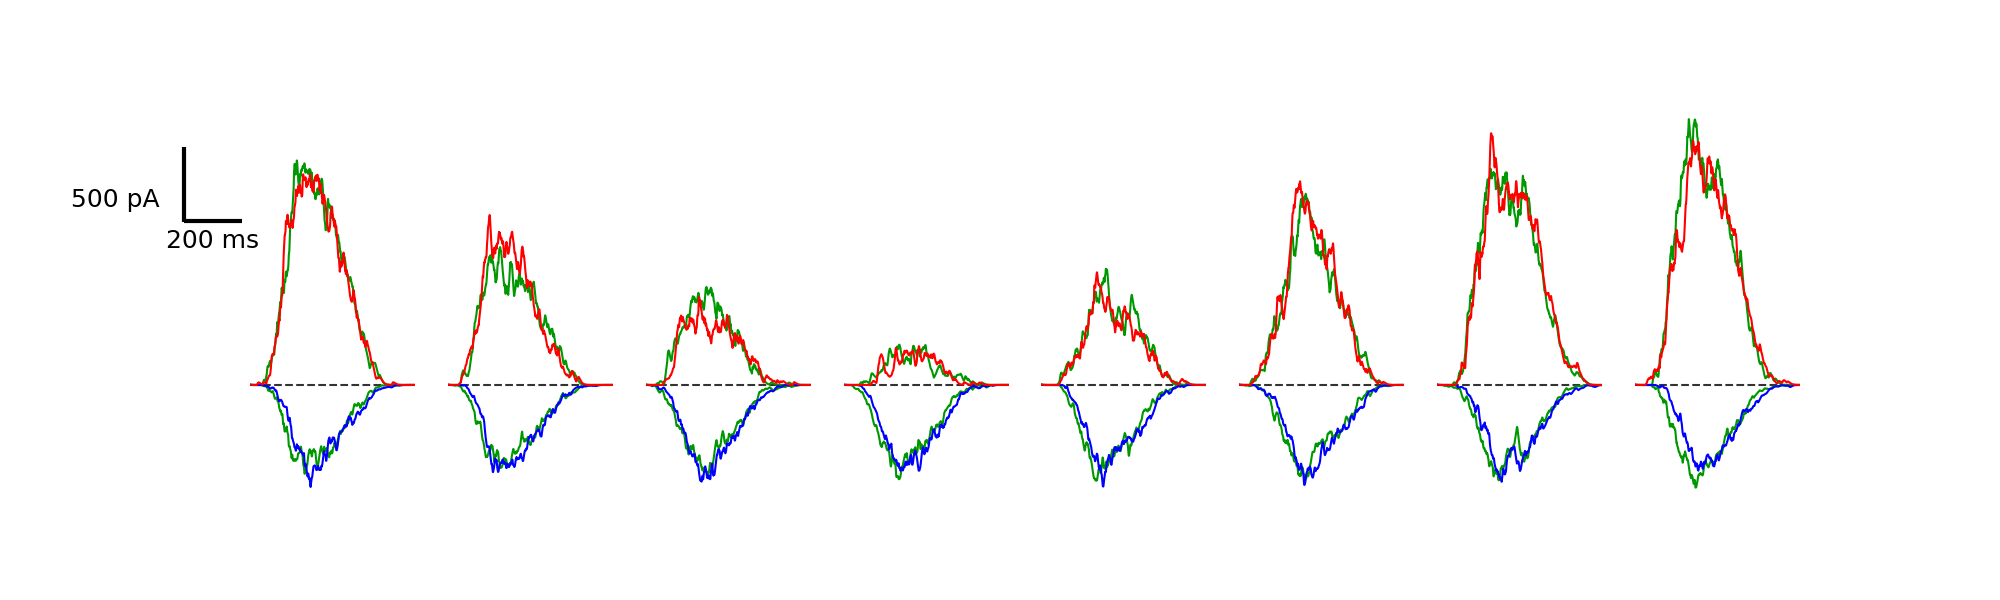

In [9]:
row_conds = [
    {"exp": ctrl_lbl, "rho":1.0},
    {"exp": expr_lbl, "rho":1.0},
    # {"exp": ctrl_lbl, "rho":0.0},
]

under_clr = "black"
under_clr = bmb_green
colours = ([(under_clr, under_clr), ("blue", "red")]
           if len(row_conds) > 1
           else  [("blue", "red")])

net = 0
trial = 0
xmin = 30
xmax = 600
vc_mode = "trial"  # net_avg, trial_avg, or trial (default)
# vc_mode = "trial_avg"
# vc_mode = "net_avg"

if vc_mode == "net_avg":
    get_vc = lambda exp, rho, trans: vc_net_avgs[exp][rho][trans]
elif vc_mode == "trial_avg":
    get_vc = lambda exp, rho, trans: vc_trial_avgs[exp][rho][net][trans]
else:
    get_vc = lambda exp, rho, trans: d[exp][rho][net]["soma"][trans][trial]

trial_vc_fig, trial_vc_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 6))

for i, ax in enumerate(trial_vc_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    for j, row in enumerate(row_conds):
        e_col, i_col = colours[j]
        ax.plot(xaxis, get_vc(row["exp"], row["rho"], "E")[i], c=e_col)
        ax.plot(xaxis, get_vc(row["exp"], row["rho"], "GABA")[i], c=i_col)
    ax.patch.set_alpha(0)

sizex = 200
sizey = 0.5
vc_sb = add_scalebar(
    trial_vc_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i pA" % (sizey * 1000),
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 400),
    textprops={"fontsize": 18},
)

clean_axes(trial_vc_ax, remove_spines=["left", "right", "top", "bottom"])
trial_vc_ax[0].set_ylim(-1, 2.1)
trial_vc_ax[0].set_xlim(xmin, xmax)

rho_tag = lambda r: "rho" +  ("%.2f" % r).replace(".", "p")
if len(row_conds) == 1:
    prefix = "vc_%s_%s" % (row_conds[0], rho_tag(row_conds[0]))
elif len(row_conds) == 2:
    k1, k2 = (cond["exp"] for cond in row_conds)
    prefix = "vc_%s_%s_%s_%s" % (k1, rho_tag(row_conds[0]["rho"]), k2, rho_tag(row_conds[0]["rho"]))
    
if vc_mode == "trial":
    name = "%s_net%i_trial%i" % (prefix, net, trial)
elif vc_mode == "trial_avg":
    name = "%s_net%i_avg" % (prefix, net)
elif vc_mode == "net_avg":
    name = "%s_all_net_avg" % prefix
for ext in exts:
    trial_vc_fig.savefig(os.path.join(fig_path, name) + ext, transparent=True)

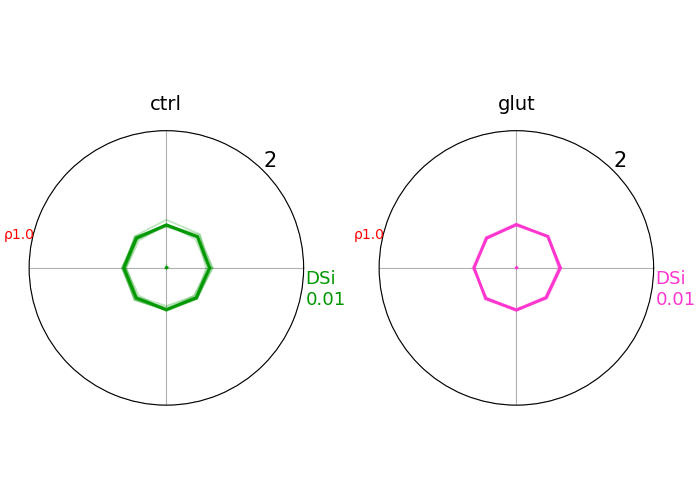

In [10]:
area_mode = False
epsc_mode = True
display_exps = exps
# display_exps = ["ctrl"]
display_rhos = rhos
display_rhos = [1.0]
# display_rhos = [0, 1.0]
# display_rhos = [0.0, 0.4, 0.8, 1.0]
radius = None if area_mode else (2 if epsc_mode else 2)

if len(display_exps) == 1 and len(display_rhos) == 2:
    colours = ["red", "black"]
    colours = [bmb_magenta, bmb_green]
elif len(display_exps) <= 2:
    colours = ["black", "red"]
    colours = [bmb_green, bmb_magenta]
else:
    colours = ["C%i" % i for i in range(15)]
    colours = [bmb_green, bmb_magenta, *colours]

metric = vc_areas if area_mode else vc_peaks
polarity = -1 if epsc_mode else 1
trans_lbl = "E" if epsc_mode else "GABA"
max_val = np.max([polarity * metric[e][r][trans_lbl] for e in exps for r in rhos])
max_val = radius if radius is not None else max_val

focus_polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_rhos))
splits = int(np.ceil(len(display_rhos) / max_rows))
n_cols = len(display_exps) * splits
focus_polar_ax = []
for i, rho in enumerate(display_rhos):
    row = i % max_rows
    subcol = i // max_rows
    for j, exp in enumerate(display_exps):
        clr_idx = j + i if len(display_exps) == 1 and len(display_rhos) == 2 else j
        focus_polar_ax.append(polar(
            metric[exp][rho][trans_lbl] * polarity,
            dir_labels,
            title=None,
            radius=max_val,
            net_shadows=True,
            fig=focus_polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            title_metrics=False,
            avg_colour=colours[clr_idx],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        focus_polar_ax[-1].text(np.radians(170), max_val * 1.2, ("ρ" + str(rho)), c="red")

for i, exp in enumerate(display_exps):
    focus_polar_ax[i].set_title(exp, fontsize=14, pad=15)
    
exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
metric_lbl = "area" if area_mode else "peak"
i_lbl = "EPSC" if epsc_mode else "IPSC"
focus_polar_fig.set_layout_engine("compressed")
for ext in exts:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "%s_rhos%s_%s_%s_polars%s" % (
            exps_lbl, rhos_lbl, i_lbl, metric_lbl, ext)), bbox_inches="tight")

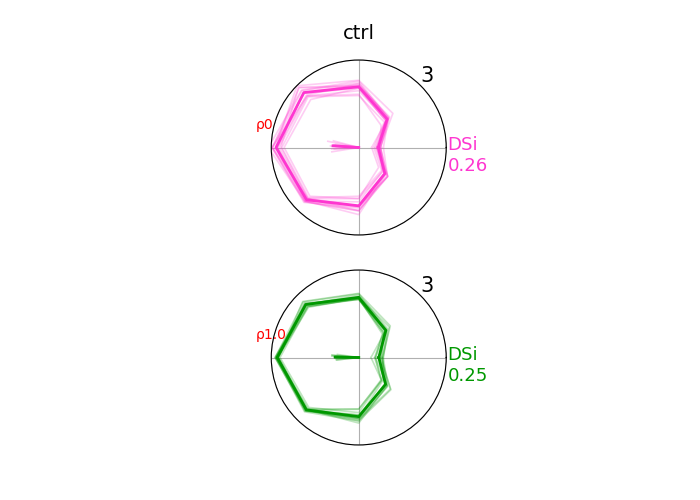

In [11]:
display_exps = exps
display_exps = ["ctrl"]
display_rhos = rhos
display_rhos = [0, 1.0]
radius = None if area_mode else (4 if "plex4_onlyn" in exps else 3)
avg_mode = False

if len(display_exps) == 1 and len(display_rhos) == 2:
    colours = ["red", "black"]
    colours = [bmb_magenta, bmb_green]
elif len(display_exps) <= 2:
    colours = ["black", "red"]
    colours = [bmb_green, bmb_magenta]
else:
    colours = ["C%i" % i for i in range(15)]
    colours = [bmb_green, bmb_magenta, *colours]

ei_ratios = (
    map_data(lambda rs: rs.reshape(1, 1, -1), avg_ei_peak_ratios)
    if avg_mode else ei_peak_ratios
)
max_val = np.max([np.max(ei_ratios[e][r]) for e in exps for r in rhos])
max_val = radius if radius is not None else max_val

ei_ratio_polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_rhos))
splits = int(np.ceil(len(display_rhos) / max_rows))
n_cols = len(display_exps) * splits
ei_ratio_polar_ax = []
for i, rho in enumerate(display_rhos):
    row = i % max_rows
    subcol = i // max_rows
    for j, exp in enumerate(display_exps):
        clr_idx = j + i if len(display_exps) == 1 and len(display_rhos) == 2 else j
        ei_ratio_polar_ax.append(polar(
            ei_ratios[exp][rho],
            dir_labels,
            title=None,
            radius=max_val,
            net_shadows=True,
            fig=ei_ratio_polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            title_metrics=False,
            avg_colour=colours[clr_idx],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        ei_ratio_polar_ax[-1].text(np.radians(170), max_val * 1.2, ("ρ" + str(rho)), c="red")

for i, exp in enumerate(display_exps):
    ei_ratio_polar_ax[i].set_title(exp, fontsize=14, pad=15)
    
focus_polar_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
avg_lbl = "avg_" if avg_mode else ""
for ext in [".png", ".svg"]:
    ei_ratio_polar_fig.savefig(
        os.path.join(fig_path, "%s_rhos%s_%sei_peak_ratio_polars%s" % (
            exps_lbl, rhos_lbl, avg_lbl, ext)), bbox_inches="tight")

In [12]:
upward_e_avgs = vc_net_avgs[ctrl_lbl][1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [ 95.7  80.5  68.3  83.5 100.6  96.4 101.3 102.1]
alignment_shifts (ms): [ 6.4 21.6 33.8 18.6  1.5  5.7  0.8  0. ]


Text(0.5, 0, 'Time (ms)')

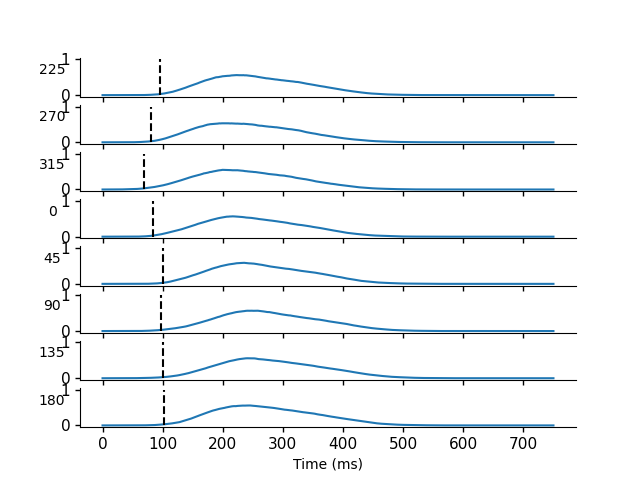

In [13]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (ms)")

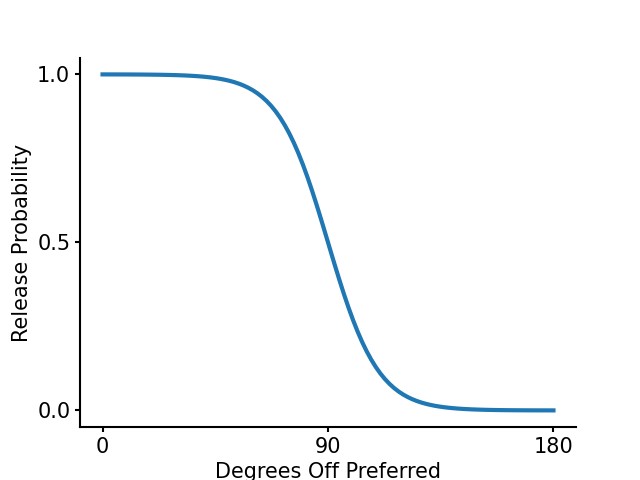

In [14]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

# null_pr = 0.05
# pref_pr = 0.95
null_pr = 0.0
pref_pr = 1.0

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr))
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, slope=null_pr))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
# sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
# sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5)
# sigmoid_fig.legend()
sigmoid_fig.savefig(os.path.join(fig_path, "prob_sigmoid.svg"), bbox_inches="tight")

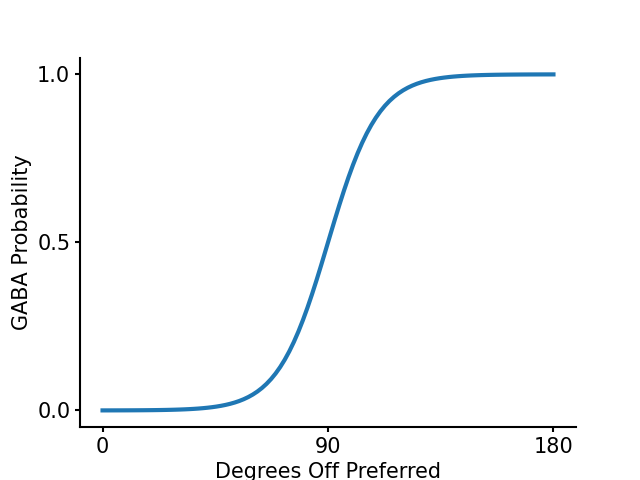

In [15]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(180 - dir_range, prob_p1, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

In [16]:
res_e = "ACH"
res_i = "GABA"
start_t = 0  # ms
start_idx = nearest_index(xaxis, start_t)
res_xaxis = xaxis[start_idx:]
residuals = {
    exp: {
        rho: {
            net: {
                k: vc_recs[exp][rho][net][k][:, :, start_idx:] - vc_trial_avgs[exp][rho][net][k][:, start_idx:]
                for k in [res_e, res_i] 
            }
            for net in idxs
        }
        for rho in rhos
    }
    for exp in exps
}

residuals_ei_sum = {
    exp: {
        rho: {
            net: residuals[exp][rho][net][res_e] + residuals[exp][rho][net][res_i]
            for net in idxs
        }
        for rho in rhos
    }
    for exp in exps
}

residuals_pos_area = map_data(lambda rs: np.clip(rs, 0, None).sum(axis=-1), residuals)
residuals_neg_area = map_data(lambda rs: np.clip(rs, None, 0).sum(axis=-1), residuals)
residuals_ei_sum_pos_area = map_data(lambda rs: np.clip(rs, 0, None).sum(axis=-1), residuals_ei_sum)
residuals_ei_sum_neg_area = map_data(lambda rs: np.clip(rs, None, 0).sum(axis=-1), residuals_ei_sum)
del residuals_ei_sum  # probably not using this again?

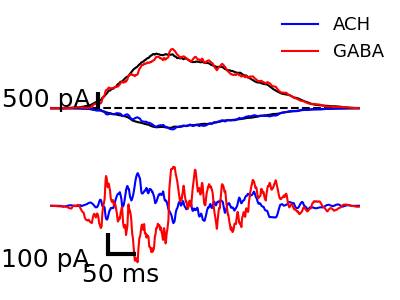

In [17]:
exp = ctrl_lbl
rho = 1.0
net = 0
trial = 2
angle = 180
normalize_resid = False
invert_i = False
scalebar_mode = True
dir_idx = np.argwhere(dir_labels == angle)[0][0]

residual_ex_fig, residual_ex_ax = plt.subplots(
    2,
    sharex=True,
    figsize=(4, 3),
)

residual_ex_ax[0].plot([np.min(xaxis), np.max(xaxis)], [0, 0], c="black", linestyle="--")
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[exp][rho][net][res_e][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[exp][rho][net][res_e][trial, dir_idx], c="blue", label=res_e)
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[exp][rho][net][res_i][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[exp][rho][net][res_i][trial, dir_idx], c="red", label=res_i)

ex_resid_e = residuals[exp][rho][net][res_e][trial, dir_idx]
ex_resid_i = residuals[exp][rho][net][res_i][trial, dir_idx]
ex_resid_i = -1 * ex_resid_i if invert_i else ex_resid_i
if normalize_resid:
    ex_resid_e = ex_resid_e / np.std(ex_resid_e)
    ex_resid_i = ex_resid_i / np.std(ex_resid_i)
residual_ex_ax[1].plot(res_xaxis, ex_resid_e, c="blue")
residual_ex_ax[1].plot(res_xaxis, ex_resid_i, c="red")

norm_prefix = "Normalized " if normalize_resid else ""
residual_ex_ax[0].set_ylim(-1, 2.2)
residual_ex_ax[-1].set_xlim(40, 550)
residual_ex_fig.legend(frameon=False, fontsize=13)

if scalebar_mode:
    vc_sb = add_scalebar(
        residual_ex_ax[0], 
        matchx=False, 
        matchy=False, 
        sizey=0.5, 
        labely="500 pA",
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(50, 200),
        textprops={"fontsize": 18},
    )
    res_sb = add_scalebar(
        residual_ex_ax[1], 
        matchx=False, 
        matchy=False, 
        sizex=50, 
        labelx="50 ms",
        sizey=0.1, 
        labely="100 pA",
        ysep=-5,
        sep=5,
        barwidth=3,
        loc="center",
        # bbox_to_anchor=(50, 70),
        bbox_to_anchor=(80, 40),
        textprops={"fontsize": 18},
    )
    clean_axes(residual_ex_ax, remove_spines=["left", "top", "right", "bottom"])
    # residual_ex_fig.set_layout_engine("compressed")
    # residual_ex_fig.tight_layout()
else:
    residual_ex_ax[0].set_ylabel("Current (nA)", fontsize=14)
    residual_ex_ax[1].set_ylabel(norm_prefix + "Residual (nA)", fontsize=14)
    residual_ex_ax[-1].set_xlabel("Time (ms)", fontsize=14)
    clean_axes(residual_ex_ax, ticksize=13, spine_width=1.5)

name = "residual_ex_%s_rho%s_net%i_d%i_tr%i%s%s%s" % (
    exp,
    str(rho).replace(".", "p"),
    net,
    angle,
    trial,
    "_norm" if normalize_resid else "",
    "_inv" if invert_i else "",
    "_scalebars" if scalebar_mode else "",
)
for ext in [".png", ".svg"]:
    residual_ex_fig.savefig(os.path.join(fig_path, name + ext), bbox_inches="tight")

In [18]:
shuffle_mode = False
shuffle_lbl = "_shuffled" if shuffle_mode else ""
shift_idxs = np.arange(n_trials) - 1
def norm_residual_xcorr(corr_mode, shuffle=False):
    return {
        exp: {
            rho: {
                i: map_axis(
                    lambda s: np.squeeze(norm_xcorr(s[0], s[1], mode=corr_mode)),
                    np.stack([net[res_e], net[res_i][shift_idxs] if shuffle else net[res_i]], axis=-2), 
                    axis=-2
                )
                for i, net in nets.items()
            }
            for rho, nets in resids.items()
        }
        for exp, resids in residuals.items()
   } 

residual_corr_valid = norm_residual_xcorr("valid", shuffle=shuffle_mode)
residual_corr_full = norm_residual_xcorr("full", shuffle=shuffle_mode)
print("full xcorr shape:", residual_corr_full[exps[0]][rhos[0]][idxs[0]].shape)

full xcorr shape: (10, 8, 15001)


In [19]:
def reduce_xcorr_trials(f, corrs):
    return {
        exp: {
            rho: {i: f(net) for i, net in nets.items()}
            for rho, nets in corrs[exp].items()
        }
        for exp in exps
    }

win_dur = 5
win_pts = int(win_dur / params["dt"])
mid_idx = len(res_xaxis) - 1
l, r = mid_idx - win_pts, mid_idx + win_pts
residual_corr_full_area = reduce_xcorr_trials(partial(np.sum, axis=-1), residual_corr_full)
residual_corr_full_midarea = reduce_xcorr_trials(lambda v: np.sum(v[:, :, l:r], axis=-1), residual_corr_full)
residual_corr_valid_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_valid)
residual_corr_full_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_full)
residual_corr_full_peak_trial_avg = reduce_xcorr_trials(partial(np.min, axis=-1), residual_corr_full_trial_avg)

def reduce_xcorr_nets(f, corrs):
    return {
        exp: {
            rho: f(np.stack([net for net in nets.values()], axis=0))
            for rho, nets in corrs[exp].items()
        }
        for exp in exps
    }
mean_ax0, std_ax0 = partial(np.mean, axis=0), partial(np.std, axis=0)
residual_corr_valid_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_peak_trial_avg)
residual_corr_valid_net_std = reduce_xcorr_nets(std_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_peak_trial_avg)

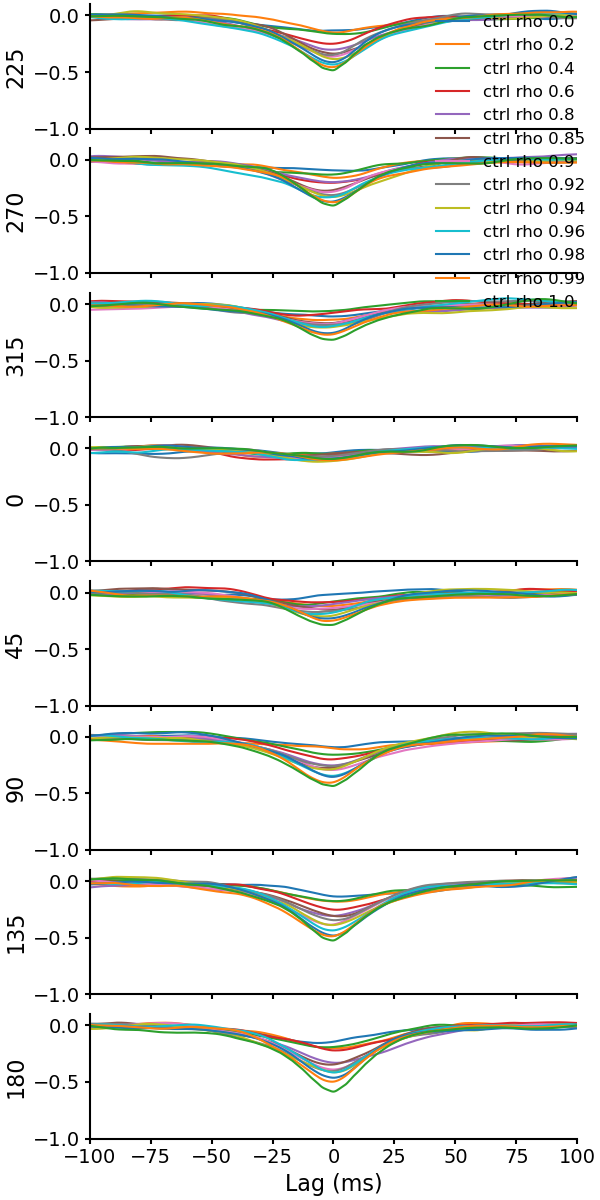

In [20]:
display_exps = exps
display_exps = [ctrl_lbl]
display_rhos = rhos
# display_rhos = [0.0, 0.4, 0.8, 1.0]

colours = ["C%i" % i for i in range(15)]
exp_styles = ["-", "--", "-.", ":"] 
exp_hatches = ["", "o", "*", "/"]
exp_hatches = ["" for _ in exp_styles]

full_xaxis = np.concatenate([np.flip(res_xaxis[1:] * -1), res_xaxis])
dir_residual_corr_fig, dir_residual_corr_ax = plt.subplots(len(dir_labels), sharex=True, sharey=True, figsize=(6, 12))
for i in range(len(dir_labels)):
    for j, exp in enumerate(display_exps):
        for rho, clr in zip(display_rhos, colours):
            lbl = ("%s rho %s" % (exp, str(rho))) if not i else None
            dir_residual_corr_ax[i].plot(
                full_xaxis,
                residual_corr_full_net_avg[exp][rho][i],
                c=clr,
                linestyle=exp_styles[j],
                label=lbl
            )
    dir_residual_corr_ax[i].set_ylabel(dir_labels[i], fontsize=16)

dir_residual_corr_ax[-1].set_xlim(-100, 100)
dir_residual_corr_ax[-1].set_ylim(-1, 0.1)
dir_residual_corr_ax[-1].set_xlabel("Lag (ms)", fontsize=16)
dir_residual_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dir_residual_corr_ax, ticksize=14, spine_width=1.5)
dir_residual_corr_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "directional_residual_xcorr_%s_%s%s" %(exps_lbl, rhos_lbl, ext)
    dir_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

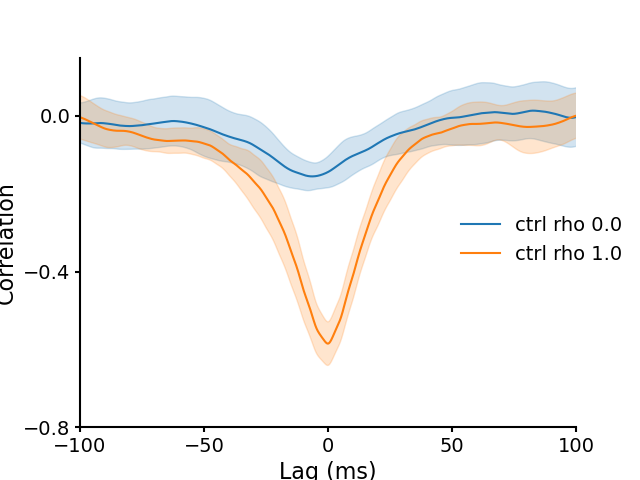

In [21]:
display_exps = exps
display_exps = [ctrl_lbl]
display_rhos = rhos
display_rhos = [0.0, 0.4, 0.8, 1.0]
display_rhos = [0.0, 1.0]
display_angle = 180
angle_idx = np.argwhere(dir_labels == display_angle)[0][0]

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}
rho_to_clr = {k: v for k, v in zip(display_rhos, colours)}

def plot_residual_corr_w_std(ax, exp, rho, dir_idx, color=None, style=None, hatch=None, alpha=0.2, label=None):
    ax.fill_between(
        full_xaxis, 
        residual_corr_full_net_avg[exp][rho][dir_idx] + residual_corr_full_net_std[exp][rho][dir_idx], 
        residual_corr_full_net_avg[exp][rho][dir_idx] - residual_corr_full_net_std[exp][rho][dir_idx], 
        alpha=alpha,
        hatch=hatch,
        **({"color": color} if color is not None else {}),
        **({"linestyle": style} if style is not None else {}),
    )
    ax.plot(
        full_xaxis, 
        residual_corr_full_net_avg[exp][rho][dir_idx],
        c=color,
        linestyle=style,
        label=label
    )
    
dir_rhos_residual_corr_fig, dir_rhos_residual_corr_ax = plt.subplots(1)
for exp in display_exps:
    for rho in display_rhos:
        lbl = "%s rho %s" % (exp, str(rho))
        plot_residual_corr_w_std(
            dir_rhos_residual_corr_ax,
            exp,
            rho,
            angle_idx,
            color=rho_to_clr[rho],
            style=exp_to_style[exp],
            hatch=exp_to_hatch[exp],
            label=lbl,
        )
    
dir_rhos_residual_corr_ax.set_xlim(-100, 100)
dir_rhos_residual_corr_ax.set_ylim(-0.8, 0.15)
dir_rhos_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
dir_rhos_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
dir_rhos_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
dir_rhos_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
dir_rhos_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(dir_rhos_residual_corr_ax, ticksize=14, spine_width=1.5)

angle_lbl = "dir_%i" % display_angle 
exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else (
    "rhos_" + "_".join(map(str, display_rhos)).replace(".", "p")
)
for ext in [".png", ".svg"]:
    name = "%s_residual_xcorr_%s_%s%s%s" % (angle_lbl, exp, rhos_lbl, shuffle_lbl, ext) 
    dir_rhos_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

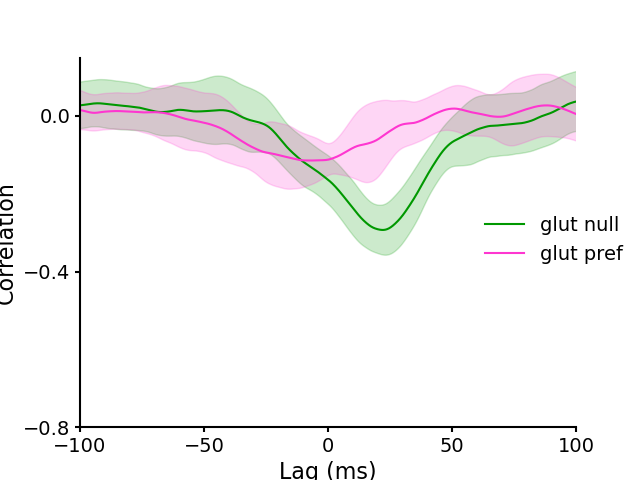

In [22]:
# display_exps = exps
# display_exps = [ctrl_lbl]
display_exps = [expr_lbl]
rho = 1
display_dirs = {
    # "null": {"idx": null_idx, "color": "black"},
    # "pref": {"idx": pref_idx, "color": "red"},
    "null": {"idx": null_idx, "color": bmb_green},
    "pref": {"idx": pref_idx, "color": bmb_magenta},
}

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}

def plot_dirs_residual_corr(ax, exp, rho, dirs, style=None, hatch=None, clr=None, incl_lbl=True):
    for lbl, ps in dirs.items(): 
        plot_residual_corr_w_std(
            ax,
            exp,
            rho,
            ps["idx"],
            color=ps["color"] if clr is None else clr,  # HACK: override colour
            style=style,
            hatch=hatch,
            label="%s %s" % (exp, lbl) if incl_lbl else None,
        )
    
dirs_residual_corr_fig, dirs_residual_corr_ax = plt.subplots(1)
for exp in display_exps:
    plot_dirs_residual_corr(
        dirs_residual_corr_ax,
        exp,
        rho,
        display_dirs,
        style=exp_to_style[exp],
        hatch=exp_to_hatch[exp],
    )
dirs_residual_corr_ax.set_xlim(-100, 100)
dirs_residual_corr_ax.set_ylim(-0.8, 0.15)
dirs_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
dirs_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
dirs_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
dirs_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
dirs_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(dirs_residual_corr_ax, ticksize=14, spine_width=1.5)

dirs_lbl = "_".join(reversed(display_dirs.keys()))
exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    name = "%s_residual_xcorr_%s_rho%s%s%s" % (dirs_lbl, exps_lbl, str(rho).replace(".", "p"), shuffle_lbl, ext)
    dirs_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

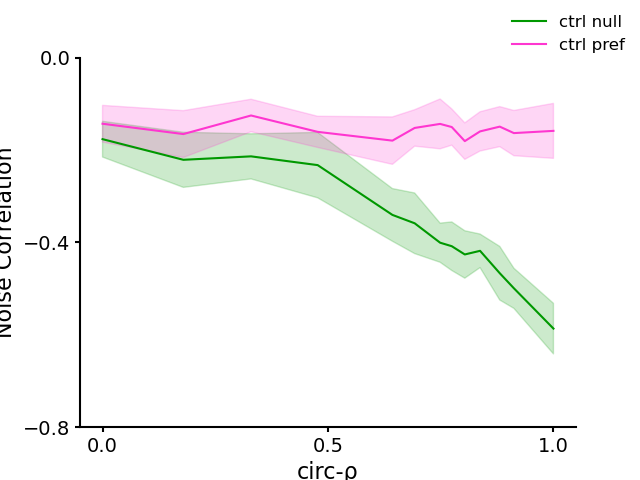

In [23]:
xaxis_mode = "fixrho"  # "width", "fixrho", "rho"
display_exps = exps
display_exps = [ctrl_lbl]
rho = 1
display_dirs = {
    # "null": {"idx": null_idx, "color": "black"},
    # "ortho": {"idx": pos_ortho_idx, "color": "blue"},
    # "pref": {"idx": pref_idx, "color": "red"},
    "null": {"idx": null_idx, "color": bmb_green},
    "pref": {"idx": pref_idx, "color": bmb_magenta},
}
show_stds = True

width_axis = 360 * (1 - fixed_rhos)
xaxis = width_axis if xaxis_mode == "width" else (fixed_rhos if xaxis_mode == "fixrho" else rhos)

rho_vs_corr_avg = {
    exp: np.stack([residual_corr_full_peak_net_avg[exp][r] for r in rhos], axis=1)
    for exp in exps
}
rho_vs_corr_std = {
    exp: np.stack([residual_corr_full_peak_net_std[exp][r] for r in rhos], axis=1)
    for exp in exps
}

rho_vs_corr_fig, rho_vs_corr_ax = plt.subplots(1)

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}

def plot_dirs_rhos_vs_corr(ax, exp, dirs, style=None, hatch=None, clr=None, incl_lbl=True):
    for dir_lbl, ps in dirs.items(): 
        i, c = ps["idx"], (ps["color"] if clr is None else clr)  # HACK: override colour
        corrs = rho_vs_corr_avg[exp][i]
        if show_stds:
            corr_stds = rho_vs_corr_std[exp][i]
            ax.fill_between(
                xaxis, corrs + corr_stds, corrs - corr_stds,
                color=c, hatch=hatch, linestyle=style, alpha=0.2
            )
        lbl = ("%s %s" % (exp, dir_lbl)) if incl_lbl else None
        ax.plot(xaxis, corrs, c=c, linestyle=style, label=lbl)
        
for exp in display_exps:
    style, hatch = exp_to_style[exp], exp_to_hatch[exp]
    plot_dirs_rhos_vs_corr(rho_vs_corr_ax, exp, display_dirs, style=style, hatch=hatch, incl_lbl=True)
    
min_y = -0.8

if xaxis_mode == "width":
    rho_vs_corr_ax.set_xticks([0, 180, 360])
else:
    rho_vs_corr_ax.set_xticks([0, 0.5, 1])
rho_vs_corr_ax.set_ylim(min_y, 0)
rho_vs_corr_ax.set_yticks([min_y, min_y / 2, 0.])
rho_vs_corr_ax.set_xlabel(
    "ACH Distribution Width (°)" if xaxis_mode == "width" else "circ-ρ", fontsize=16)
rho_vs_corr_ax.set_ylabel("Noise Correlation", fontsize=16)
rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(rho_vs_corr_ax, ticksize=14, spine_width=1.5)

x_lbl = "ACH_dist_width" if xaxis_mode == "width" else xaxis_mode
exps_lbl = "_".join(display_exps)
dirs_lbl = "_".join(reversed(display_dirs.keys()))
for ext in [".png", ".svg"]:
    name = "%s_vs_residual_xcorr_%s_dirs_%s%s%s" % (x_lbl, exps_lbl, dirs_lbl, shuffle_lbl, ext)
    rho_vs_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

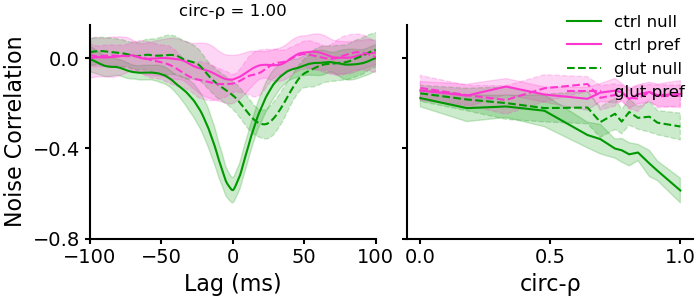

In [24]:
display_exps = exps
# display_exps = [ctrl_lbl]
# display_exps = [expr_lbl]
rho = 1
display_dirs = {
    # "null": {"idx": null_idx, "color": "black"},
    # "pref": {"idx": pref_idx, "color": "red"},
    "null": {"idx": null_idx, "color": bmb_green},
    "pref": {"idx": pref_idx, "color": bmb_magenta},
}

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}
dirs_xcorr_and_rho_vs_corr_fig, dirs_xcorr_and_rho_vs_corr_ax = plt.subplots(
    1, 2, 
    sharey=True, 
    # gridspec_kw={"width_ratios": [0.6, 0.4]},
    gridspec_kw={"width_ratios": [0.5, 0.5]},
    figsize=(7, 3),
)
xcorr_subax, rhos_subax = dirs_xcorr_and_rho_vs_corr_ax

for exp in display_exps:
    style, hatch = exp_to_style[exp], exp_to_hatch[exp]
    plot_dirs_residual_corr(xcorr_subax, exp, rho, display_dirs, style=style, hatch=hatch, incl_lbl=False)
    plot_dirs_rhos_vs_corr(rhos_subax, exp, display_dirs, style=style, hatch=hatch, incl_lbl=True)

min_y = -0.8
xcorr_subax.set_title("circ-ρ = %.2f" % calc_fixrho(rho))
xcorr_subax.set_xlim(-100, 100)
xcorr_subax.set_xticks([-100, -50, 0, 50, 100])
xcorr_subax.set_ylim(min_y, 0.15)
xcorr_subax.set_yticks([min_y, min_y / 2, 0.])
xcorr_subax.set_xlabel("Lag (ms)", fontsize=16)
xcorr_subax.set_ylabel("Noise Correlation", fontsize=16)
rhos_subax.set_xticks([0, 0.5, 1])
rhos_subax.set_xlabel("circ-ρ", fontsize=16)
dirs_xcorr_and_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dirs_xcorr_and_rho_vs_corr_ax, ticksize=14, spine_width=1.5)
dirs_xcorr_and_rho_vs_corr_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
dirs_lbl = "_".join(map(str, display_dirs))
rho_lbl = str(rho).replace(".", "p")
for ext in [".png", ".svg"]:
    name = os.path.join(
        fig_path,
        "lag_and_rho_vs_residual_xcorr_%s_dirs_%s_rho%s%s%s" % (exps_lbl, dirs_lbl, rho_lbl, shuffle_lbl, ext)
    )
    dirs_xcorr_and_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

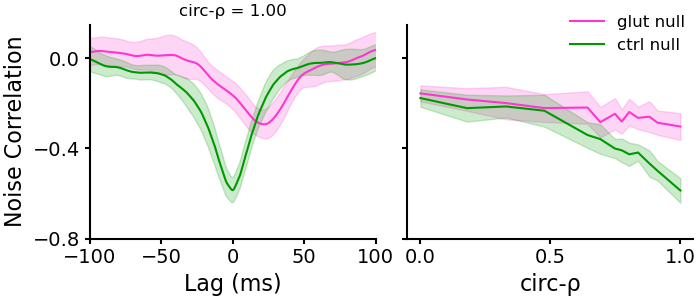

In [25]:
display_exps = reversed(exps)
# display_exps = [ctrl_lbl]
# display_exps = [expr_lbl]
rho = 1

display_dirs = {"null": {"idx": null_idx, "color": bmb_green}}
clrs = [bmb_magenta, bmb_green]

null_xcorr_and_rho_vs_corr_fig, null_xcorr_and_rho_vs_corr_ax = plt.subplots(
    1, 2,
    sharey=True, 
    # gridspec_kw={"width_ratios": [0.6, 0.4]},
    gridspec_kw={"width_ratios": [0.5, 0.5]},
    figsize=(7, 3),
)
xcorr_subax, rhos_subax = null_xcorr_and_rho_vs_corr_ax
for exp, c in zip(display_exps, clrs):
    plot_dirs_residual_corr(xcorr_subax, exp, rho, display_dirs, style="-", clr=c, incl_lbl=False)
    plot_dirs_rhos_vs_corr(rhos_subax, exp, display_dirs, style="-", clr=c, incl_lbl=True)


min_y = -0.8
xcorr_subax.set_title("circ-ρ = %.2f" % calc_fixrho(rho))
xcorr_subax.set_xlim(-100, 100)
xcorr_subax.set_xticks([-100, -50, 0, 50, 100])
xcorr_subax.set_ylim(min_y, 0.15)
xcorr_subax.set_yticks([min_y, min_y / 2, 0.])
xcorr_subax.set_xlabel("Lag (ms)", fontsize=16)
xcorr_subax.set_ylabel("Noise Correlation", fontsize=16)
rhos_subax.set_xticks([0, 0.5, 1])
rhos_subax.set_xlabel("circ-ρ", fontsize=16)
null_xcorr_and_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(null_xcorr_and_rho_vs_corr_ax, ticksize=14, spine_width=1.5)
null_xcorr_and_rho_vs_corr_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
dirs_lbl = "_".join(map(str, display_dirs))
rho_lbl = str(rho).replace(".", "p")
for ext in [".png", ".svg"]:
    name = os.path.join(
        fig_path,
        "lag_and_rho_vs_residual_xcorr_%s_null_only_rho%s%s%s" % (exps_lbl, rho_lbl, shuffle_lbl, ext)
    )
    null_xcorr_and_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

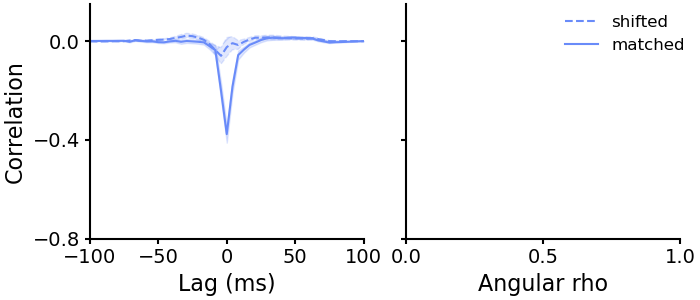

In [26]:
ben_corr_avg_path = "/home/geoff/git/notes/balance_paper/from_ben/Correlation Avg"
chr2_xcorr_avg = np.loadtxt(os.path.join(ben_corr_avg_path, "Im_112_1_1_1_inh_extract_0_res_corr_avg.csv"), skiprows=1)
chr2_xcorr_sem = np.loadtxt(os.path.join(ben_corr_avg_path, "Im_112_1_1_1_inh_extract_0_res_corr_sem.csv"), skiprows=1)
shifted_xcorr_avg = np.loadtxt(os.path.join(ben_corr_avg_path, "corrSwitch_0_avg.csv"), skiprows=1)
shifted_xcorr_sem = np.loadtxt(os.path.join(ben_corr_avg_path, "corrSwitch_0_sem.csv"), skiprows=1)

chr2_xaxis = np.linspace(-100, 100, len(chr2_xcorr_avg))

ben_chr2_fig, ben_chr2_ax = plt.subplots(
    1, 2, 
    sharey=True, 
    # gridspec_kw={"width_ratios": [0.6, 0.4]},
    gridspec_kw={"width_ratios": [0.5, 0.5]},
    figsize=(7, 3),
)
xcorr_subax, rhos_subax = ben_chr2_ax

# ben_chr2_fig, ben_chr2_ax = plt.subplots(1)
# xcorr_subax = ben_chr2_ax

avg_clr = chr2_blue
avg_ls = "-"
avg_hatch = None
shifted_clr = chr2_blue
shifted_ls = "--"
shifted_hatch = "/"

xcorr_subax.fill_between(
    chr2_xaxis, 
    shifted_xcorr_avg + shifted_xcorr_sem, 
    shifted_xcorr_avg - shifted_xcorr_sem, 
    color=shifted_clr,
    alpha=0.2,
    linestyle=shifted_ls,
    hatch=shifted_hatch,
)
xcorr_subax.plot(chr2_xaxis, shifted_xcorr_avg, c=shifted_clr, ls=shifted_ls, label="shifted")
xcorr_subax.fill_between(
    chr2_xaxis, 
    chr2_xcorr_avg + chr2_xcorr_sem, 
    chr2_xcorr_avg - chr2_xcorr_sem, 
    color=avg_clr,
    alpha=0.2,
    linestyle=avg_ls,
    hatch=avg_hatch,
)
xcorr_subax.plot(chr2_xaxis, chr2_xcorr_avg, c=avg_clr, ls=avg_ls, label="matched")


min_y = -0.8
# xcorr_subax.set_title("chr2 flash ")
# xcorr_subax.set_title("rho 1.0")
xcorr_subax.set_xlim(-100, 100)
xcorr_subax.set_xticks([-100, -50, 0, 50, 100])
xcorr_subax.set_ylim(min_y, 0.15)
xcorr_subax.set_yticks([min_y, min_y / 2, 0.])
xcorr_subax.set_xlabel("Lag (ms)", fontsize=16)
# xcorr_subax.set_ylabel("Noise Correlation", fontsize=16)
xcorr_subax.set_ylabel("Correlation", fontsize=16)
rhos_subax.set_xticks([0, 0.5, 1])
# rhos_subax.set_xlabel("circ-ρ", fontsize=16)
rhos_subax.set_xlabel("Angular rho", fontsize=16)
ben_chr2_fig.legend(frameon=False, fontsize=12)
clean_axes(ben_chr2_ax, ticksize=14, spine_width=1.5)
ben_chr2_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    name = os.path.join(
        fig_path,
        "ben_chr2_empty_rho_range%s" % (ext)
    )
    ben_chr2_fig.savefig(name, bbox_inches="tight")

In [27]:
pack_hdf(
    os.path.join(fig_path, "analysis" + shuffle_lbl),
    {
        "rhos": rhos,
        "dir_labels": dir_labels,
        "xaxis": xaxis,
        "full_xaxis": full_xaxis,
        "sac_thetas": sac_thetas,
        "sac_deltas": sac_deltas,
        "vc_trial_avgs": vc_trial_avgs,
        "vc_net_avgs": vc_net_avgs,
        "vc_peaks": vc_peaks,
        "vc_areas": vc_areas,
        "gaba_peak_dsis": gaba_peak_dsis,
        "gaba_peak_thetas": gaba_peak_thetas,
        "gaba_area_dsis": gaba_area_dsis,
        "gaba_area_thetas": gaba_area_thetas,
        "residual_corr_valid": residual_corr_valid,
        "residual_corr_valid_trial_avg": residual_corr_valid_trial_avg,
        "residual_corr_valid_net_avg": residual_corr_valid_net_avg,
        "residual_corr_valid_net_std": residual_corr_valid_net_std,
        "residual_corr_full_area": residual_corr_full_area,
        "residual_corr_full_midarea": residual_corr_full_midarea,
        "residual_corr_full_net_avg": residual_corr_full_net_avg,
        "residual_corr_full_peak_net_avg": residual_corr_full_peak_net_avg,
        "residual_corr_full_net_std": residual_corr_full_net_std,
        "residual_corr_full_peak_net_std": residual_corr_full_peak_net_std,
        "residuals_pos_area": residuals_pos_area,
        "residuals_neg_area": residuals_neg_area,
        "residuals_ei_sum_pos_area": residuals_ei_sum_pos_area,
        "residuals_ei_sum_neg_area": residuals_ei_sum_neg_area,
        "rho_vs_corr_avg": rho_vs_corr_avg,
        "rho_vs_corr_std": rho_vs_corr_std,
    }
)

In [28]:
close_button()

In [29]:
chr2_xaxis

array([-100.        ,  -95.83333333,  -91.66666667,  -87.5       ,
        -83.33333333,  -79.16666667,  -75.        ,  -70.83333333,
        -66.66666667,  -62.5       ,  -58.33333333,  -54.16666667,
        -50.        ,  -45.83333333,  -41.66666667,  -37.5       ,
        -33.33333333,  -29.16666667,  -25.        ,  -20.83333333,
        -16.66666667,  -12.5       ,   -8.33333333,   -4.16666667,
          0.        ,    4.16666667,    8.33333333,   12.5       ,
         16.66666667,   20.83333333,   25.        ,   29.16666667,
         33.33333333,   37.5       ,   41.66666667,   45.83333333,
         50.        ,   54.16666667,   58.33333333,   62.5       ,
         66.66666667,   70.83333333,   75.        ,   79.16666667,
         83.33333333,   87.5       ,   91.66666667,   95.83333333,
        100.        ])